### Goal
Estimate the critical percolation threshold for the forest fire model but with Von Neumann neighborhoods. Confirm the analytical result by conducting simulations.

### Task 1
Repeat the renormalization group analysis in Sayama, but with **Von Neumann neighborhoods** (see Figure 11.2 in the textbook). Make your notes in this notebook or in a separate Google Doc, if that is easier.

<span class="minerva-question" style='background-color:#5cb85c;padding: 5px 20px 5px 20px;line-height:30px;color:white;font-weight: bold; border-radius: 25px'>Question 1</span>

What is the conductance of a 2 x 2 grid when using Von Neumann neighborhoods?

$$p_2=p_1^4+4\cdot p_1^3\cdot\left(1-p_1\right)+2\cdot p_1^2\cdot\left(1-p_1\right)^2$$

<span class="minerva-question" style='background-color:#5cb85c;padding: 5px 20px 5px 20px;line-height:30px;color:white;font-weight: bold; border-radius: 25px'>Question 2</span>

What is the conductance of a 2n x 2n grid in terms of a n x n grid? (That is, what is the scale mapping $p_{s+1} = \Phi(p_s)$?)

$$p_{s+1}=\Phi\left(p_s\right)=p_s^4+4\cdot p_s^3\cdot\left(1-p_s\right)+2\cdot p_s^2\cdot\left(1-p_s\right)^2$$

<span class="minerva-question" style='background-color:#5cb85c;padding: 5px 20px 5px 20px;line-height:30px;color:white;font-weight: bold; border-radius: 25px'>Question 3</span>

Make a cobweb plot of your result in Step 3.

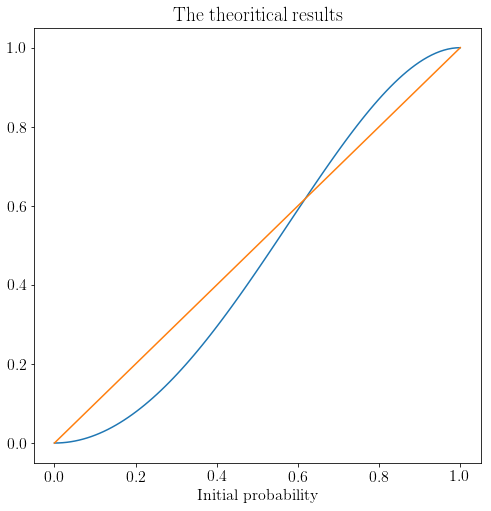

In [7]:
import numpy as np
def func(p):
    return p**4 + 4*p**3*(1-p) + 2*p**2*(1-p)**2

x = np.linspace(0,1, 100)
theo_p = [func(_) for _ in x]
diag = [_ for _ in x]
plt.figure(figsize=(8, 8))
plt.plot(x, theo_p, label="theoritical")
plt.plot(x, diag, label="diagonal")
plt.title("The theoritical results")
plt.xlabel("Initial probability")
plt.show()

<span class="minerva-question" style='background-color:#5cb85c;padding: 5px 20px 5px 20px;line-height:30px;color:white;font-weight: bold; border-radius: 25px'>Question 4</span>

What is the critical initial tree density, $q$, where percolation starts occurring?

$$p_c=p_c^4+4\cdot p_c^3\cdot\left(1-p_c\right)+2\cdot p_c^2\cdot\left(1-p_c\right)^2$$

$$p_c=\left\{0,\ 1,\ -\frac{1}{2}-\sqrt{5},\ -\frac{1}{2}+\sqrt{5}\right\}$$

The point that we're interested in is when $0<p_c<1$ which in this case is:
$$p_c=\frac{-1+\sqrt{5}}{2}=0.618034$$

### Task 2

* Modify the forest fire simulation below to use the Von Neumann neighborhood rather than the Moore neighborhood.
* Generate a plot of the proportion of trees burnt out as a function of the initial tree density. (You can run the existing code to see what this looks like for the Moore neighborhood.)
* How do your experimental results compare with your theoretical results from Task 1?

In [8]:
import matplotlib.pyplot as plt
import scipy as sp


class ForestFireSimulation:

    empty, tree, fire, char = [0, 1, 2, 3]  # Setup state values

    def __init__(self, size=50):
        self.size = size
        self.state = sp.zeros((size, size))

    def initialize(self, tree_density=0.4):

        self.state.fill(self.empty)

        # Place random trees with the requested density
        random_indexes = sp.random.choice(
            range(self.size ** 2),
            size=int(round(tree_density * self.size ** 2)),
            replace=False)
        self.state.flat[random_indexes] = self.tree

        # Ignite one random tree
        if len(random_indexes) > 0:
            self.state.flat[random_indexes[0]] = self.fire

        self.time_step = 0
        self.changed = True  # Track whether the state changed between the
                             # previous time step and the current one

    def draw(self):
        plt.cla()
        plt.pcolor(self.state, vmin = 0, vmax = 3, cmap = plt.cm.binary)
        plt.axis('image')
        plt.title('t = ' + str(self.time_step))

    def update(self):
        self.time_step += 1

        next_state = sp.zeros(self.state.shape)
        # Empty cells stay empty
        next_state[sp.where(self.state == self.empty)] = self.empty
        # Charred cells stay charred
        next_state[sp.where(self.state == self.char)] = self.char
        # Burning cells become charred
        next_state[sp.where(self.state == self.fire)] = self.char

        # Check which trees should be ignited (all those with fire neighbors)
        ys, xs = sp.where(self.state == self.tree)
        fire_neighbor = sp.zeros(len(xs), dtype=bool)
        #Moore Neighborhood
        for dx in [-1, 0, 1]:
            fire_neighbor = fire_neighbor | (self.state[(ys) % self.size, (xs + dx) % self.size] == self.fire)
        for dy in [-1, 0, 1]:
            fire_neighbor = fire_neighbor | (self.state[(ys + dy) % self.size, (xs) % self.size] == self.fire)
        # Trees with burning neighbors start burning
        next_state[(ys[fire_neighbor], xs[fire_neighbor])] = self.fire
        # Trees without burning neighbors stay the same
        next_state[(ys[~fire_neighbor], xs[~fire_neighbor])] = self.tree

        self.changed = (next_state != self.state).any()
        self.state = next_state

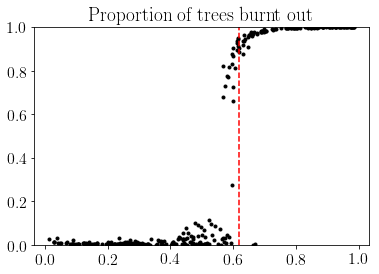

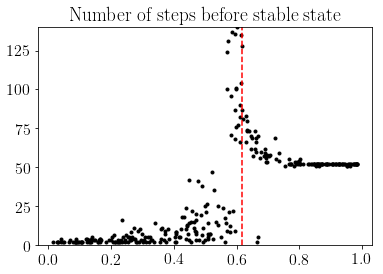

In [9]:
sim = ForestFireSimulation()

# The initial tree density at which all trees will burn out according
# to the renormalization group analysis, shown on the plots below.
theoretical_critical = 0.618034

# Run experiments and record data for the result plots
plot_data = {
    'prob': [],   # The initial tree density
    'burnt': [],  # The proportion of trees that burned out
    'time': []}   # The number of steps for the simulation to stabilize
for experiment in range(300):
    tree_density = sp.random.uniform(0.01, 1)
    sim.initialize(tree_density)
    while sim.changed:  # Run until the state stops changing
        sim.update()
    plot_data['prob'].append(tree_density)
    plot_data['time'].append(sim.time_step)
    plot_data['burnt'].append((sim.state == sim.char).mean() / tree_density)

# Plot experimental results
plt.figure()
plt.plot(plot_data['prob'], plot_data['burnt'], 'k.')
plt.plot([theoretical_critical, theoretical_critical], [0, 1], 'r--')
plt.ylim(0, 1)
plt.title('Proportion of trees burnt out')

plt.figure()
plt.plot(plot_data['prob'], plot_data['time'], 'k.')
plt.plot([theoretical_critical, theoretical_critical], [0, max(plot_data['time'])], 'r--')
plt.ylim(0, max(plot_data['time']))
plt.title('Number of steps before stable state')

plt.show()

## Cobweb Plot algorithm

In [0]:
# Way to make Cobweb plots with Latex titles
# Code from https://scipython.com/blog/cobweb-plots/
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt

# Use LaTeX throughout the figure for consistency
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
# Figure dpi
dpi = 72

def plot_cobweb(f, r, x0, nmax=40):
    """Make a cobweb plot.

    Plot y = f(x; r) and y = x for 0 <= x <= 1, and illustrate the behaviour of
    iterating x = f(x) starting at x = x0. r is a parameter to the function.

    """
    x = np.linspace(0, 1, 500)
    fig = plt.figure(figsize=(600/dpi, 450/dpi), dpi=dpi)
    ax = fig.add_subplot(111)

    # Plot y = f(x) and y = x
    ax.plot(x, f(x, r), c='#444444', lw=2)
    ax.plot(x, x, c='#444444', lw=2)

    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, nmax, 2):
        px[n] = px[n-1]
        py[n] = f(px[n-1], r)
        px[n+1] = py[n]
        py[n+1] = py[n]

    # Plot the path traced out by the iteration.
    ax.plot(px, py, c='b', alpha=0.7)

    # Annotate and tidy the plot.
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=0.5)
    ax.set_aspect('equal')
    ax.set_xlabel('$x$')
    ax.set_ylabel(f.latex_label)
    ax.set_title('$x_0 = {:.1}, r = {:.2}$'.format(x0, r))

    plt.savefig('cobweb_{:.1}_{:.2}.png'.format(x0, r), dpi=dpi)

class AnnotatedFunction:
    """A small class representing a mathematical function.

    This class is callable so it acts like a Python function, but it also
    defines a string giving its latex representation.

    """

    def __init__(self, func, latex_label):
        self.func = func
        self.latex_label = latex_label

    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

# The logistic map, f(x) = rx(1-x).
func = AnnotatedFunction(lambda x,r: x**4 + 4*x**3*(1-x) + 2*x**2*(1-x)**2, r'$rx(1-x)$')

plot_cobweb(func, 2.8, 0.2)
plot_cobweb(func, 3.8, 0.2, 200)